In [1]:
from glob import glob
import os

malignant_dataset_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant'
benign_dataset_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign'
normal_dataset_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal'

class_names = ['benign', 'malignant', 'normal']
# Getting the Image and Mask files from dataset
benign_image_url = glob(os.path.join(benign_dataset_dir, '*).png'))
benign_mask_url = glob(os.path.join(benign_dataset_dir, '*_mask*'))
    
malignant_image_url = glob(os.path.join(malignant_dataset_dir, '*).png'))
malignant_mask_url = glob(os.path.join(malignant_dataset_dir, '*_mask*'))

normal_image_url = glob(os.path.join(normal_dataset_dir, '*).png'))
normal_mask_url = glob(os.path.join(normal_dataset_dir, '*_mask*'))

normal_dataset_dir + '/' + normal_dataset_dir.split('/')[-1] + ' ' + normal_image_url[1].split('/')[-1].split(' ')[-1].split('.')[0] + '_mask.png'

'/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (51)_mask.png'

In [2]:
from torch.utils.data import Dataset
import cv2

class ImageDataset(Dataset):
    
    def __init__(self, dataset_dir, image_urls, mask_urls, transforms):
        
        self.image_urls = image_urls
        self.mask_urls = mask_urls
        self.transform = transforms
        self.dataset_dir = dataset_dir
        
    def __getitem__(self, index):
        
        image = self.image_urls[index]
        mask_name = self.dataset_dir + '/' + self.dataset_dir.split('/')[-1] + ' ' + image.split('/')[-1].split(' ')[-1].split('.')[0] + '_mask.png'
        
        if not os.path.exists(os.path.join(self.dataset_dir, mask_name)):
            mask_name = self.dataset_dir + '/' + self.dataset_dir.split('/')[-1] + ' ' + image.split('/')[-1].split(' ')[-1].split('.')[0] + '_mask_1.png'
            
        mask_index = self.mask_urls.index(mask_name)
        mask = self.mask_urls[mask_index]
        
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask, 0)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        label_name = self.dataset_dir.split('/')[-1]
        label = class_names.index(label_name)
        label = torch.tensor(label)
        
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)
                        
        return (image, label, mask)
            
    def __len__(self):
        return len(self.image_urls)

In [3]:
from torch.utils.data import ConcatDataset
import torchvision.transforms.v2 as v2
import torchvision
import torch

mean, std = torch.zeros(3), torch.zeros(3)

num_images = len(benign_image_url)

for image in benign_image_url:
    image = cv2.imread(image)
    image = torch.tensor(image, dtype = torch.float32).permute(2, 0, 1).contiguous().view(3, -1) / 255
    mean += image.mean(dim=1)

mean /= num_images

for image in benign_image_url:
    image = cv2.imread(image)
    image = torch.tensor(image, dtype = torch.float32).permute(2, 0, 1).contiguous().view(3, -1) / 255
    std += ((image - mean.unsqueeze(1))**2).sum(dim=1)

std = torch.sqrt(std / (num_images * image.size(1)))

mean, std = mean.tolist(), std.tolist()

# Mean Values = [0.33827683329582214, 0.33835434913635254, 0.3383665382862091]
# Standard Deviation Values = [0.30563297867774963, 0.3056659400463104, 0.30566325783729553]

effects = v2.Compose([
    v2.ToImage(),
    v2.Grayscale(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(degrees=(0, 180)),
    v2.Resize(size = (1024, 1024), antialias=True),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean, std)
])

benign_dataset = ImageDataset(benign_dataset_dir, benign_image_url, benign_mask_url, effects)
malignant_dataset = ImageDataset(malignant_dataset_dir, malignant_image_url, malignant_mask_url, effects)
normal_dataset = ImageDataset(normal_dataset_dir, normal_image_url, normal_mask_url, effects)

dataset = ConcatDataset([benign_dataset, malignant_dataset, normal_dataset])

In [4]:
dataset[0][0][0]

tensor([[-1.1068, -1.1068, -1.1068,  ..., -1.1068, -1.1068, -1.1068],
        [-1.1068, -1.1068, -1.1068,  ..., -1.1068, -1.1068, -1.1068],
        [-1.1068, -1.1068, -1.1068,  ..., -1.1068, -1.1068, -1.1068],
        ...,
        [-1.1068, -1.1068, -1.1068,  ..., -1.1068, -1.1068, -1.1068],
        [-1.1068, -1.1068, -1.1068,  ..., -1.1068, -1.1068, -1.1068],
        [-1.1068, -1.1068, -1.1068,  ..., -1.1068, -1.1068, -1.1068]])

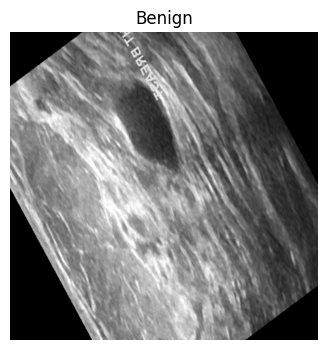

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

for image, label, mask in dataset:
    
    image = np.transpose(image, (1, 2, 0))
    
    mean = torch.tensor(mean)
    std = torch.tensor(std)
    
    image = image * std + mean
    image = image.numpy().astype(np.uint8)
    
    plt.figure(figsize = (4, 4))
    plt.imshow(image)
    plt.title(class_names[label].capitalize())
    plt.axis('off')
    
    plt.show()
    
    break

In [6]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

train_size = int(len(dataset) * 0.75)
valid_size = int(len(dataset) * 0.125)
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

batch_size = 4

train_dataset = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataset = DataLoader(valid_dataset, batch_size = batch_size, shuffle = True)
test_dataset = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print(f'Images in Train Dataset: {len(train_dataset.dataset)}')
print(f'Images in Validation Dataset: {len(valid_dataset.dataset)}')
print(f'Images in Test Dataset: {len(test_dataset.dataset)}')

Images in Train Dataset: 585
Images in Validation Dataset: 97
Images in Test Dataset: 98


In [7]:
from transformers import SamProcessor, SamModel
import torch.nn as nn

processor = SamProcessor.from_pretrained('wanglab/medsam-vit-base')
model = SamModel.from_pretrained("ayoubkirouane/Breast-Cancer_SAM_v1")

total_layers = len(list(model.parameters()))
layers_to_freeze = int(total_layers * 0.85)

for i, parameter in enumerate(model.parameters()):
    if i < layers_to_freeze:
        parameter.requires_grad = False
        
for name, child in model.named_children():
    if 'layer' in name:
        for name2, child2 in child.named_children:
            setattr(child, name2, nn.Sequential(child2, nn.Dropout(0.65), nn.BatchNorm2d()))

2024-03-10 07:50:28.324236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 07:50:28.324364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 07:50:28.462442: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/375M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
from accelerate import Accelerator

epochs = 2
lr = 0.001

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr = lr, weight_decay = 0.01)

accelerator = Accelerator()

model, optimizer, train_dataset, valid_dataset, test_dataset = accelerator.prepare(
    model, optimizer, train_dataset, valid_dataset, test_dataset
)

loss_fn = torch.nn.BCEWithLogitsLoss()

model.use_bfloat16 = True
optimizer.loss_scaling_factor = 1.0 
model.mixed_precision = True

In [9]:
from IPython.display import clear_output, display
import pandas as pd

train_losses, val_losses, data, dataframe = [], [], [], []
columns = ["Epoch", "Train Loss", 'Validation Loss', 'Train IOU', 'Validation IOU']

for epoch in range(epochs):
    
    train_loss, train_total, avg_iou_train, total_ious, avg_train_loss, avg_iou_train = 0, 0, 0, 0, 0, 0
    model.train()
    
    for i, (images, labels, masks) in enumerate(train_dataset):
        
        images = images.type(torch.bfloat16)
        outputs = model(images.float())
    
        pred_masks = outputs['pred_masks'].to(torch.bfloat16)
        masks = masks.type(torch.bfloat16)
        
        pred_masks = v2.Resize(size = (256, 256), antialias=True)(pred_masks)
        masks = v2.Resize(size = (256, 256), antialias=True)(masks)
        
        try: mask_loss = loss_fn(pred_masks.view(batch_size, -1), masks.view(batch_size, -1))
        except ValueError: pass
        
        if (outputs['iou_scores'] > 1).any():
            iou_loss = outputs['iou_scores'] - 1
        else:
            iou_loss = 1 - outputs['iou_scores']
    
        loss = torch.sum(iou_loss + mask_loss).to(torch.bfloat16)
        train_loss += loss.item()
    
        avg_train_loss = train_loss / (i + 1)
        train_losses.append(loss.item())
    
        train_total += outputs['iou_scores'].reshape(-1).size(0)
        total_ious += torch.sum(outputs['iou_scores']).item()
        avg_iou_train = total_ious / (train_total + 1e-7)
    
        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
    
        clear_output(wait = True)
        print(f'Epoch: {epoch + 1}, Train Loss: {avg_train_loss:.3f}, Train IOU: {avg_iou_train:.2f}')
    
    with torch.no_grad():
        
        val_loss, total, avg_iou, total_ious_val = 0,0,0,0
        
        for i, (images, labels, masks) in enumerate(valid_dataset):
            
            images = images.type(torch.bfloat16)
            outputs = model(images.float())
            
            masks = v2.Resize(size = (256, 256), antialias=True)(masks)
            pred_masks = v2.Resize(size = (256, 256), antialias=True)(pred_masks)
            
            masks = masks.type(torch.bfloat16)
        
            try: mask_loss = loss_fn(pred_masks.view(batch_size, -1), masks.view(batch_size, -1))
            except ValueError: pass
        
            if (outputs['iou_scores'] > 1).any():
                iou_loss = outputs['iou_scores'] - 1
            else:
                iou_loss = 1 - outputs['iou_scores']
    
            loss = torch.sum(iou_loss + mask_loss)
            val_loss += loss.item()
    
            avg_val_loss = val_loss / (i + 1)
            val_losses.append(loss.item())
    
            total += outputs['iou_scores'].reshape(-1).size(0)
            total_ious_val += torch.sum(outputs['iou_scores']).item()
            avg_iou = total_ious_val / (total + 1e-7)
            
            data.append([epoch + 1, avg_train_loss, avg_val_loss, avg_iou_train, avg_iou])
            df = pd.DataFrame(data, columns = columns).reset_index(drop = True)
                
            clear_output(wait = True)
            display(df.tail(1))
                
    dataframe.append([epoch + 1, avg_train_loss, avg_val_loss, avg_iou_train, avg_iou])
    dataf = pd.DataFrame(dataframe, columns = columns).reset_index(drop = True)
    clear_output(wait = True)
    display(dataf)

,Epoch,Train Loss,Validation Loss,Train IOU,Validation IOU
0,1,-4.571100e+09,-6.883457e+10,0.945788,0.902890
1,2,-3.839420e+11,-2.283970e+11,0.921815,0.902644


In [10]:
with torch.no_grad():
    
    test_loss, total_test, avg_iou_test, total_ious_test = 0,0,0,0
        
    for i, (images, labels, masks) in enumerate(test_dataset):
        
        images = images.type(torch.bfloat16)
        outputs = model(images.float())
        
        masks = v2.Resize(size = (256, 256), antialias=True)(masks)
        pred_masks = v2.Resize(size = (256, 256), antialias=True)(pred_masks)
            
        masks = masks.type(torch.bfloat16)
        
        try: mask_loss = loss_fn(pred_masks.view(batch_size, -1), masks.view(batch_size, -1))
        except ValueError: pass
        
        if (outputs['iou_scores'] > 1).any():
            iou_loss = outputs['iou_scores'] - 1
        else:
            iou_loss = 1 - outputs['iou_scores']
    
        loss = torch.sum(iou_loss + mask_loss)
        test_loss += loss.item()
    
        avg_test_loss = test_loss / (i + 1)
    
        total_test += outputs['iou_scores'].reshape(-1).size(0)
        total_ious_test += torch.sum(outputs['iou_scores']).item()
        avg_iou_test = total_ious_test / (total + 1e-7)
        
        clear_output(wait = True)
        print(f'Test Loss: {avg_test_loss:.3f}, Test IOU: {avg_iou_test:.2f}')

Test Loss: 43011413114.880, Test IOU: 0.91


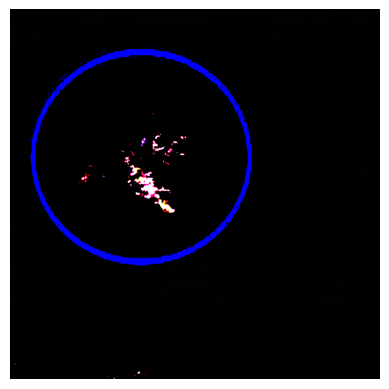

In [11]:
from torchvision.transforms import ToTensor
from PIL import Image
import requests

# The cancer is in the circle
img_url = 'https://s3.amazonaws.com/static.wd7.us/9/90/Mamma_ca_1.jpg'

raw_image = Image.open(requests.get(img_url, stream = True).raw).convert('RGB')

model = model.to('cpu')

image = v2.Resize(size = (1024, 1024), antialias=True)(raw_image)
image = ToTensor()(image).unsqueeze(0)
image = v2.Normalize(mean, std)(image)
image = np.array(image).astype(np.uint8)

inputs = processor(image, return_tensors="pt")
outputs = model(**inputs)
masks = outputs['pred_masks']

plt.imshow(image.squeeze(0).transpose(1, 2, 0))
plt.axis('off')
plt.show()

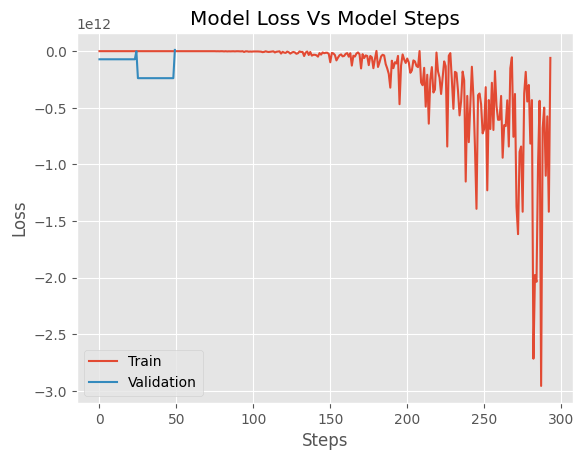

In [12]:
plt.style.use("ggplot")
plt.plot(train_losses)
plt.plot(val_losses)

plt.title('Model Loss Vs Model Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')

plt.legend(['Train', 'Validation'])
plt.show()

In [13]:
torch.save(model, '/kaggle/working/model.pt')
torch.save(model.state_dict(), '/kaggle/working/inference.pt')